In [90]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import nearest_points
from IPython.display import display
from datetime import timedelta, date, datetime
pd.options.display.max_columns = None

In [504]:
joined = pd.read_csv('chi_collisions/joined2.csv', low_memory=False)

In [505]:
joined = joined[['trans_id', 'CRASH_DA_1']]
joined = joined.rename({'CRASH_DA_1': 'date_and_time'}, axis=1)
joined.trans_id = joined.trans_id.astype(int)
joined.date_and_time = pd.to_datetime(joined.date_and_time)

In [506]:
streets_file = 'chi_roads/Street Center Lines/geo_export_3707e052-5aa1-4bf6-8676-474b93a57dde.shp'
streets = gpd.GeoDataFrame.from_file(streets_file)
streets['longitude'] = streets.centroid.x
streets['latitude'] = streets.centroid.y
streets = streets[['trans_id','class', 'dir_travel', 'length', 'street_nam', 'street_typ', 'latitude', 'longitude']]
streets.trans_id = streets.trans_id.astype(int)

In [507]:
joined = pd.merge(left=joined, right=streets, left_on='trans_id', right_on='trans_id', how='outer')

In [509]:
crashes = joined[joined.date_and_time.notnull()]
crashes = crashes[crashes.date_and_time >= '2017-7-1']

In [510]:
roads = joined[joined.trans_id.duplicated(keep='first') == False]

In [511]:
traffic_counts = pd.read_csv('chi_roads/traffic_counts.csv')
traffic_counts = traffic_counts.rename({'join_trans_id': 'trans_id', 'Total Passing Vehicle Volume': 'volume'}, axis=1)

In [512]:
traffic_counts = traffic_counts[['trans_id', 'volume']]

In [513]:
roads_full = pd.merge(left=roads, right=traffic_counts, left_on='trans_id', right_on='trans_id', how='left')
traffic_counts = pd.merge(left=traffic_counts, right=roads, left_on='trans_id', right_on='trans_id')

In [514]:
roads_points = [Point(xy) for xy in zip(roads_full.latitude, roads_full.longitude)]
counts_points = [Point(xy) for xy in zip(traffic_counts.latitude, traffic_counts.longitude)]
traffic_counts['geo'] = counts_points
roads_full['geo'] = roads_points

In [515]:
c = 0
for i, row in roads_full.iterrows():
    if c % 1000 == 0:
        print(c)
    c+=1
    if pd.isna(row.volume):
        to_check = traffic_counts[traffic_counts['class'] == row['class']]
        min_dist = 1000000
        min_vol = 0
        for j, row2 in to_check.iterrows():
            d = row.geo.distance(row2.geo)
            if d < min_dist:
                min_dist = d
                min_vol = row2.volume
        roads_full.loc[i, 'volume'] = min_vol

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000


In [516]:
vol_map = roads_full.copy().set_index('trans_id')['volume'].to_dict()
roads_to_sample = roads_full[roads_full.volume != 0]

In [517]:
crashes['volume'] = crashes.apply(lambda x: vol_map[x.trans_id], axis=1)

In [518]:
pos_events = crashes.copy().reset_index().drop(['trans_id'], axis=1)
pos_events['crash'] = 1
pos_events['month'] = pos_events.date_and_time.dt.month
pos_events['weekday'] = pos_events.date_and_time.dt.dayofweek
pos_events['hour'] = pos_events.date_and_time.dt.hour

In [519]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days) * 24):
        yield start_date + timedelta(hours=n)

In [520]:
start_date = datetime(2017, 9, 1)
end_date = datetime(2019, 11, 1)

neg_events = []
c = 0
for single_date in daterange(start_date, end_date):
    pddate = pd.to_datetime(single_date)
    m = pddate.month
    d = pddate.weekday()
    h = pddate.hour
    if c % 500 == 0:
        print(pddate)
    c += 1
    df = roads_to_sample.sample(n=70).copy()
    df['date_and_time'] = pddate
    df['month'] = m
    df['weekday'] = d
    df['hour'] = h
    neg_events.append(df)


neg_events = pd.concat(neg_events)

2017-09-01 00:00:00
2017-09-21 20:00:00
2017-10-12 16:00:00
2017-11-02 12:00:00
2017-11-23 08:00:00
2017-12-14 04:00:00
2018-01-04 00:00:00
2018-01-24 20:00:00
2018-02-14 16:00:00
2018-03-07 12:00:00
2018-03-28 08:00:00
2018-04-18 04:00:00
2018-05-09 00:00:00
2018-05-29 20:00:00
2018-06-19 16:00:00
2018-07-10 12:00:00
2018-07-31 08:00:00
2018-08-21 04:00:00
2018-09-11 00:00:00
2018-10-01 20:00:00
2018-10-22 16:00:00
2018-11-12 12:00:00
2018-12-03 08:00:00
2018-12-24 04:00:00
2019-01-14 00:00:00
2019-02-03 20:00:00
2019-02-24 16:00:00
2019-03-17 12:00:00
2019-04-07 08:00:00
2019-04-28 04:00:00
2019-05-19 00:00:00
2019-06-08 20:00:00
2019-06-29 16:00:00
2019-07-20 12:00:00
2019-08-10 08:00:00
2019-08-31 04:00:00
2019-09-21 00:00:00
2019-10-11 20:00:00


In [536]:
data = pos_events.append(neg_events, ignore_index=True, sort=True)

In [537]:
data['date'] = data['date_and_time'].dt.date
data = data.drop(['index', 'geo'], axis=1)

In [538]:
weather = pd.read_csv('chi_weather_daily.csv')[['Date', 'Avg Temp', 'Precipitation Water Equiv', 'Snowfall']]

In [539]:
weather['Date'] = pd.to_datetime(weather['Date']).dt.date

In [540]:
data = pd.merge(left=data, right=weather, left_on='date', right_on='Date')

In [541]:
data = data.fillna(value={'Snowfall': 0, 'crash': 0}).drop(['date', 'Date', 'date_and_time'], axis=1)

In [545]:
data.crash = data.crash.astype(int)

In [575]:
data.to_csv('data.csv')

In [566]:
roads_data = roads_to_sample[['class', 'dir_travel', 'latitude', 'length',
       'longitude', 'street_nam', 'street_typ', 'trans_id', 'volume']]

In [591]:
from sklearn import svm
from sklearn import preprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle

In [592]:
data = pd.read_csv("./data.csv", index_col=0)
data.crash = data.crash.fillna(0)

In [593]:
def get_scaled_value(value, mean, std):
    return (value - mean)/ std

In [594]:
min_max_scaler = preprocessing.MinMaxScaler()

In [595]:
data = data.sample(frac=1).reset_index(drop=True)

In [596]:
data[['hour']] = (data[['hour']] - 12)/ 12
data[['month']] = (data[['month']] - 6) / 6

In [597]:
avg_temp_mean = data[['Avg Temp']].mean(axis = 0)
avg_temp_std = data[['Avg Temp']].std(axis = 0)
avg_rain_mean = data[['Precipitation Water Equiv']].mean(axis = 0)
avg_rain_std = data[['Precipitation Water Equiv']].std(axis = 0)
avg_snow_mean = data[['Snowfall']].mean(axis = 0)
avg_snow_std = data[['Snowfall']].std(axis = 0)
length_mean = data[['length']].mean(axis = 0)
length_std = data[['length']].std(axis = 0)

In [598]:
max_volume = 165200
min_volume = 0
min_lat = 41.644670131999995
max_lat = 42.022779861
min_long = -87.933976504
max_long = -87.52458738699998
avg_temp_mean = 52.736361
avg_temp_std = 20.625818
avg_rain_mean = 0.117716
avg_rain_std = 0.329548
avg_snow_mean = 0.012092
avg_snow_std = 0.104858
length_mean = 439.04927
length_std = 207.835484

In [599]:
data.volume = (data.volume - min_volume) / (max_volume - min_volume)
data.latitude = (data.latitude - min_lat) / (max_lat - min_lat)
data.longitude = (data.longitude - min_long) / (max_long - min_long)

In [600]:
data = pd.concat([data,pd.get_dummies(data['weekday'], prefix='weekday')],axis=1)

In [601]:
data = pd.concat([data,pd.get_dummies(data['class'], prefix='class')],axis=1)

In [602]:
data[['Avg Temp']] = get_scaled_value(data[['Avg Temp']], avg_temp_mean, avg_temp_std)
data[['Precipitation Water Equiv']] = get_scaled_value(data[['Precipitation Water Equiv']], avg_rain_mean, avg_rain_std)
data[['Snowfall']] = get_scaled_value(data[['Snowfall']], avg_snow_mean, avg_snow_std)
data[['length']] = get_scaled_value(data[['length']], avg_snow_mean, avg_snow_std)

In [603]:
data['one_way'] = np.where((data.dir_travel == 'T') | (data.dir_travel == 'F'), 1, 0)

In [604]:
data.one_way = data.one_way.astype(int)
data.crash = data.crash.astype(int)
data = data[data['class'].isna() == False]
data = data[data['latitude'].isna() == False]
data = data[data['longitude'].isna() == False]

In [648]:
y = data[['crash']]
X = data.drop(['crash', 'street_nam', 'street_typ', 'trans_id',
               'dir_travel', 'class', 'weekday'], axis=1)
X = X.to_numpy()
y = y.to_numpy()

train_x = X[:-300000, :]
train_y = y[:-300000, 0].tolist()
test_x = X[-300000:, :]
test_y = y[-300000:, 0].tolist()

In [606]:
clf = RandomForestClassifier(n_estimators=50, random_state=0, class_weight='balanced_subsample')
clf.fit(train_x, train_y)

print(clf.feature_importances_)

pred_y = clf.predict(test_x)
print("Accuracy:",metrics.accuracy_score(test_y, pred_y))

[1.32141460e-01 1.58387852e-01 1.43212663e-01 1.49552146e-01
 5.59284695e-02 7.93911921e-02 9.99513136e-02 5.81472730e-02
 3.93942582e-03 7.05008428e-03 6.92334389e-03 7.05306243e-03
 6.90631413e-03 6.52678320e-03 7.53315461e-03 7.31131425e-03
 1.46582092e-03 1.51433853e-02 8.68926155e-03 2.71250248e-02
 1.87779635e-04 6.93549080e-04 1.83370029e-03 2.35851046e-04
 3.47658047e-03 1.31351810e-03 6.35748154e-07 9.87904154e-03]
Accuracy: 0.8077266666666667


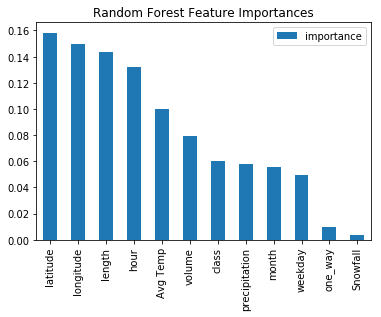

In [609]:
feats = clf.feature_importances_.tolist()
cols = data.drop(['crash', 'street_nam', 'street_typ', 'trans_id',
               'dir_travel', 'class', 'weekday'], axis=1).columns.tolist()
weekday_imp = sum(feats[9:16])
class_imp = sum(feats[16:-1])
feats = feats[:9] + [weekday_imp, class_imp] + feats[-1:]
cols = cols[:9] + ['weekday', 'class'] + cols[-1:]
cols[7] = 'precipitation'
feat_importances = pd.DataFrame(feats, index=cols, columns=['importance']).sort_values(by='importance', ascending=False)
feat_importances.plot.bar()
plt.title('Random Forest Feature Importances')
plt.show()

In [610]:
pickle.dump(clf, open('random_forest.sav', 'wb'))

In [567]:
roads_data = roads_data.drop(['street_nam', 'street_typ'], axis=1)

In [568]:
roads_data['one_way'] = np.where((roads_data.dir_travel == 'T') | (roads_data.dir_travel == 'F'), 1, 0)
roads_data.one_way = roads_data.one_way.astype(int)
roads_data = roads_data.drop(['dir_travel'], axis=1)
roads_data = roads_data[roads_data['class'].isna() == False]
roads_data = roads_data[roads_data['latitude'].isna() == False]
roads_data = roads_data[roads_data['longitude'].isna() == False]

In [569]:
roads_data.volume = (roads_data.volume - min_volume) / (max_volume - min_volume)
roads_data.latitude = (roads_data.latitude - min_lat) / (max_lat - min_lat)
roads_data.longitude = (roads_data.longitude - min_long) / (max_long - min_long)

In [570]:
roads_data = pd.concat([roads_data,pd.get_dummies(roads_data['class'], prefix='class')],axis=1)
roads_data = roads_data.drop(['class'], axis=1)

In [571]:
roads_data = roads_data.set_index('trans_id')

In [627]:
roads_data = roads_data[roads_data.isnull().any(axis=1) == False]

In [628]:
roads_data.to_csv('street_segments.csv')

In [650]:
clf = pickle.load(open('random_forest.sav', 'rb'))
street_data = pd.read_csv("street_segments.csv", index_col=0)

In [651]:
street_data['hour'] = 10
street_data['month'] = 9
street_data['weekday'] = 3
street_data['Avg Temp'] = 70
street_data['Precipitation Water Equiv'] = 0
street_data['Snowfall'] = 0

In [652]:
def get_scaled_value(value, mean, std):
    return (value - mean)/ std

In [653]:
max_volume = 165200
min_volume = 0
min_lat = 41.644670131999995
max_lat = 42.022779861
min_long = -87.933976504
max_long = -87.52458738699998
avg_temp_mean = 52.736361
avg_temp_std = 20.625818
avg_rain_mean = 0.117716
avg_rain_std = 0.329548
avg_snow_mean = 0.012092
avg_snow_std = 0.104858
length_mean = 439.04927
length_std = 207.835484

In [654]:
street_data[['hour']] = (street_data[['hour']] - 12)/ 12
street_data[['month']] = (street_data[['month']] - 6) / 6

In [655]:
street_data = pd.concat([street_data,pd.get_dummies(street_data['weekday'], prefix='weekday')],axis=1)
street_data = street_data.drop(['weekday'], axis=1)

In [656]:
street_data[['Avg Temp']] = get_scaled_value(street_data[['Avg Temp']], avg_temp_mean, avg_temp_std)
street_data[['Precipitation Water Equiv']] = get_scaled_value(street_data[['Precipitation Water Equiv']], avg_rain_mean, avg_rain_std)
street_data[['Snowfall']] = get_scaled_value(street_data[['Snowfall']], avg_snow_mean, avg_snow_std)
street_data[['length']] = get_scaled_value(street_data[['length']], avg_snow_mean, avg_snow_std)

In [659]:
one_hot_cols = ['weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5',
       'class_7', 'class_9', 'class_99', 'class_E', 'class_RIV', 'class_S']
cols = set(street_data.columns.tolist())
for col in one_hot_cols:
    if col not in cols:
        street_data[col] = 0

In [662]:
X = street_data[['hour', 'latitude', 'length', 'longitude', 'month', 'volume',
       'Avg Temp', 'Precipitation Water Equiv', 'Snowfall', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5',
       'class_7', 'class_9', 'class_99', 'class_E', 'class_RIV', 'class_S',
       'one_way']]

,hour,latitude,length,longitude,month,volume,Avg Temp,Precipitation Water Equiv,Snowfall,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,class_1,class_2,class_3,class_4,class_5,class_7,class_9,class_99,class_E,class_RIV,class_S,one_way
trans_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118772,-0.166667,0.640056,4187.287179,0.781293,0.5,1.000000,0.836992,-0.357204,-0.115318,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
145323,-0.166667,0.636218,6050.242187,0.780796,0.5,0.115012,0.836992,-0.357204,-0.115318,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
130283,-0.166667,0.264617,6348.405737,0.779657,0.5,0.118644,0.836992,-0.357204,-0.115318,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
164056,-0.166667,0.267045,1703.079835,0.780393,0.5,0.056295,0.836992,-0.357204,-0.115318,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
128038,-0.166667,0.338027,6318.041220,0.861244,0.5,0.317797,0.836992,-0.357204,-0.115318,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117620,-0.166667,0.680079,3067.683624,0.627176,0.5,0.143462,0.836992,-0.357204,-0.115318,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
164888,-0.166667,0.419517,2342.050462,0.535892,0.5,0.042373,0.836992,-0.357204,-0.115318,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
164890,-0.166667,0.420259,1922.351205,0.536989,0.5,0.042373,0.836992,-0.357204,-0.115318,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [676]:
preds_y = clf.predict_proba(X)
safety_scores = pd.Series(preds_y[:,0].tolist())

In [677]:
street_segs = street_data[['latitude', 'longitude']]
street_segs['safety_score'] = safety_scores.values

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,latitude,longitude,safety_score
trans_id,,,
118772,0.640056,0.781293,0.46
145323,0.636218,0.780796,0.38
130283,0.264617,0.779657,0.50
164056,0.267045,0.780393,0.82
128038,0.338027,0.861244,0.70
...,...,...,...
117620,0.680079,0.627176,0.56
164888,0.419517,0.535892,0.98
164890,0.420259,0.536989,0.96
